In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

paths = Path.cwd() / "data"
paths = list(paths.glob("*.*"))

In [2]:
# Import and preprocess dataset 2
df_trans = pd.read_csv(paths[2], dtype={"TRANS_LV1":"category","TRANS_LV2":"category","DAY_OF_WEEK":"category"}, parse_dates=[2])
df_trans["TRANS_ID"] = df_trans.index
df_trans.index = df_trans["TRANS_DATE"]
# Import and preprocess dataset 3
df_actv = pd.read_csv(paths[3], dtype={"DAY_OF_WEEK":"category","ACTIVITY_NAME":"category"}, parse_dates=[0])
df_actv["ACTIVITY_ID"] = df_actv.index
df_actv.index = df_actv["ACTIVITY_DATE"]

<AxesSubplot:>

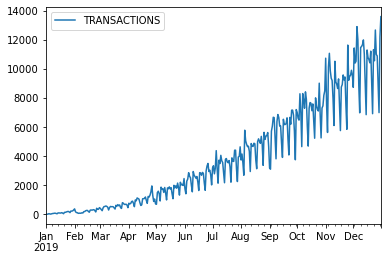

In [3]:
trans_count = df_trans[["CUSTOMER_NUMBER", "TRANS_ID"]].groupby(["TRANS_DATE", "CUSTOMER_NUMBER"]).count()
trans_count = trans_count.rename(columns={"TRANS_ID":"TRANSACTIONS"})
trans_count_all = trans_count.sum(level=0)
trans_count_all = trans_count_all.reindex(pd.date_range(start="2019-01-01", end="2019-12-31"), fill_value=0)
trans_count_all.plot()

<AxesSubplot:>

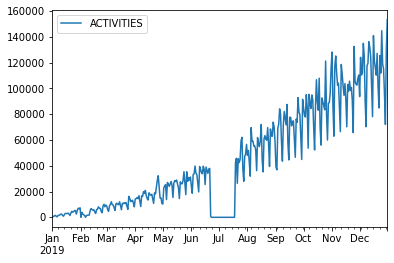

In [4]:
actv_count = df_actv[["CUSTOMER_NUMBER", "ACTIVITY_ID"]].groupby(["ACTIVITY_DATE", "CUSTOMER_NUMBER"]).count()
actv_count = actv_count.rename(columns={"ACTIVITY_ID":"ACTIVITIES"})
actv_count_all = actv_count.sum(level=0)
actv_count_all = actv_count_all.reindex(pd.date_range(start="2019-01-01", end="2019-12-31"), fill_value=0)
actv_count_all.plot()

Database had problems from 22/6 to 18/7. Records missing on 22/6 and then stopped coming for the whole period.
Cross examine with MyVIB transaction shows that people still using the service during that period.
Furthermore, the trend after suggests the blackout might not be experienced by the users, otherwise we would see major drop off and return to normal behaviour (instead of continuing as is).
Need to take MyVIB Transaction into account

In [5]:
df = pd.concat([trans_count, actv_count], join="outer", axis=1)
df["IS_ACTIVE"] = df["TRANSACTIONS"].notna() | df["ACTIVITIES"].notna()
# uncensored inactive durations
df_inactive = df["IS_ACTIVE"].index.to_frame().groupby(level=1).diff()
df_inactive = df_inactive[0]
df_inactive_duration = df_inactive.dropna().astype("timedelta64[D]")
df_inactive_duration = df_inactive_duration[df_inactive_duration > 1]
df_inactive_duration.value_counts()

2.0      377786
3.0      212992
4.0      133272
5.0       90380
6.0       65974
          ...  
255.0         1
333.0         1
278.0         1
353.0         1
294.0         1
Name: 0, Length: 311, dtype: int64

<AxesSubplot:>

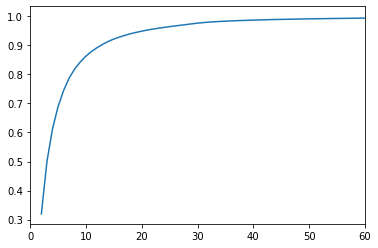

In [6]:
# Make a nice cumulative plot
cum_days = df_inactive_duration.value_counts() / df_inactive_duration.value_counts().sum()
cumsum_days = cum_days.sort_index().cumsum()
cumsum_days.plot(style="-",xlim=(0,60))

In [7]:
# 5% false positive rate
possible_cutoff_duration = cumsum_days[cumsum_days >= 0.95]
possible_cutoff_duration

21.0     0.952666
22.0     0.955932
23.0     0.958962
24.0     0.961731
25.0     0.964325
           ...   
333.0    0.999997
337.0    0.999997
338.0    0.999998
346.0    0.999999
353.0    1.000000
Name: 0, Length: 292, dtype: float64

In [8]:
cutoff_duration = possible_cutoff_duration.index.min()
cutoff_duration

21.0

So cut off at 21 days is a good rate. We expect to see only 5% false positive (customers that exceeded the inactive duration yet returned way later)  
Apply the cutoff duration on the censored to determine if user is churned

In [9]:
# censored inactive duration